# Delayed Acceptance example: Predator/Prey model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from scipy.integrate import solve_ivp

import tinyDA as tda

In [2]:
np.random.seed(987)

### Define the predator/prey model
We use scipy.integrate.solve_ivp to solve the predator-prey model. The method `dydx` is the differential equation.

In [3]:
class PredatorPreyModel:
    def __init__(self, datapoints):
        
        # set the timesteps, where we are collecting the model output
        self.datapoints = datapoints
        
        # set the span of the integration.
        self.t_span = [0, self.datapoints[-1]]
        
    def dydx(self, t, y, a, b, c, d):
        # Lotka-Volterra Model model, see e.g. https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations
        return np.array([a*y[0] - b*y[0]*y[1], c*y[0]*y[1] - d*y[1]])

    def __call__(self, parameters):
        
        # extract the parameters, and take the exponential to keep them positive
        P_0, Q_0, a, b, c, d = np.exp(parameters)
        
        # solve the initial value problem.
        self.y = solve_ivp(lambda t, y: self.dydx(t, y, a, b, c, d), self.t_span, np.array([P_0, Q_0]), t_eval=self.datapoints) 
        
        # return the results, only if the integration succeeded.
        if self.y.success:
            return self.y.y.flatten()
        else:
            return np.nan
        
    def get_qoi(self):
        # collect the integration success status for diagnostics purposes
        return self.y.success

### Set up the true model

In [4]:
# #set the true parameters
P_0 = 10
Q_0 = 5
a = 1.0
b = 0.3
c = 0.2
d = 1.0

# collect the parameters in a vector and take the logarithm. 
# we sample the log of the parameters and take the exponential
# inside the model to keep the parameters positive.
true_parameters = np.log(np.array([P_0, Q_0, a, b, c, d]))

# set the integration points.
t_span = [0,12]
n_eval = 1000
t_eval = np.linspace(t_span[0], t_span[1], n_eval)

# initalise the true model and solve it
my_model = PredatorPreyModel(t_eval)
y_true = my_model(true_parameters)

### Set up the forward models

In [5]:
# fine model
n_data_fine = 25 # number of datapoints
t_eval_fine = np.linspace(t_span[0], t_span[1], n_data_fine) # datapoints
my_fine_model = PredatorPreyModel(t_eval_fine) # initialise model

# coarse model (stops integrating halfway through)
n_data_coarse = 13 # number of datapoints
t_eval_coarse = t_eval_fine[:n_data_coarse] # datapoints (the first 13 of the fine model)
my_coarse_model = PredatorPreyModel(t_eval_coarse) # initialise model

### Generate data

In [6]:
# set the noise level
sigma = 1.0

noise_fine = np.random.normal(scale=sigma, size=(t_eval_fine.size,2)) # fine noise
data_fine = my_fine_model(true_parameters) + np.hstack((noise_fine[:,0], noise_fine[:,1])) # noisy fine data.
data_fine[data_fine < 0] = 0 # make sure all the data is positive.

noise_coarse = np.hstack((noise_fine[:n_data_coarse,0], noise_fine[:n_data_coarse,1])) # coarse noise
data_coarse = my_coarse_model(true_parameters) + noise_coarse # noisy coarse data
data_coarse[data_coarse < 0] = 0 # make sure all the data is positive.

### Plot the true model and the data

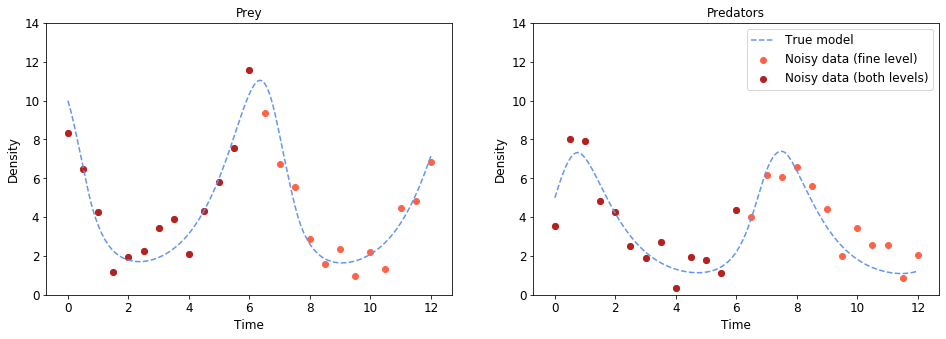

In [7]:
fig, axes = plt.subplots(figsize=(16,5), nrows=1, ncols=2)

axes[0].set_title('Prey', fontsize=12)
axes[0].plot(t_eval, y_true[:n_eval], '--', color='cornflowerblue')
#axes[0].scatter(t_eval_fine, data_fine[:n_data_fine]-noise_fine[:,0], color='cornflowerblue')
axes[0].scatter(t_eval_fine, data_fine[:n_data_fine], color='tomato', label='Noisy data (fine level)')
axes[0].scatter(t_eval_coarse, data_coarse[:n_data_coarse], color='firebrick', label='Noisy data (both levels)')
#axes[0].plot([], [], '--', color='cornflowerblue', label = 'True model')
axes[0].tick_params(axis='both', labelsize=12)
axes[0].set_xlabel('Time', fontsize=12)
axes[0].set_ylim(0, 14); axes[0].set_ylabel('Density', fontsize=12)
#axes[0].legend(loc=2, fontsize=12)

axes[1].set_title('Predators', fontsize=12)
axes[1].plot(t_eval, y_true[n_eval:], '--', color='cornflowerblue')
#axes[1].scatter(t_eval_fine, data_fine[n_data_fine:]-noise_fine[:,1], color='cornflowerblue')
axes[1].scatter(t_eval_fine, data_fine[n_data_fine:], color='tomato', label='Noisy data (fine level)')
axes[1].scatter(t_eval_coarse, data_coarse[n_data_coarse:], color='firebrick', label='Noisy data (both levels)')
axes[1].plot([], [], '--', color='cornflowerblue', label = 'True model')
axes[1].tick_params(axis='both', labelsize=12)
axes[1].set_xlabel('Time', fontsize=12)
axes[1].set_ylim(0, 14); axes[1].set_ylabel('Density', fontsize=12)
axes[1].legend(loc=1, fontsize=12)

plt.show()

### Set up the statistical model  and draw some samples from the prior
We need a fairly well-informed prior, since the model is nonlinear and the data is quite noisy. Hence, we assume that we have pretty good knowledge about the birth- and death rates of the prey and predators, respectively. The predation rate and the growth rate for the predators are left to be fairly uncertain.

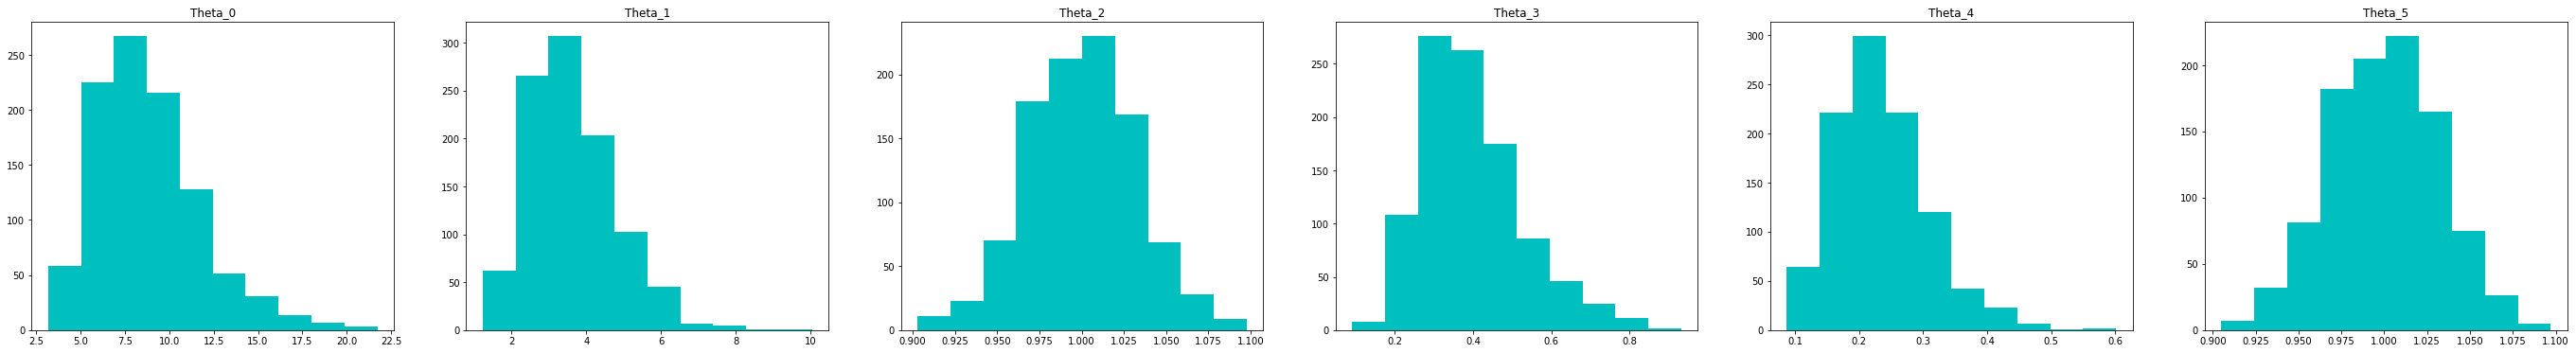

In [8]:
# prior distribution
mean_prior = np.array([np.log(data_fine[0]), np.log(data_fine[n_data_fine]), 0, -1, -1.5, 0])
cov_prior = np.diag([0.1, 0.1, 0.001, 0.1, 0.1, 0.001])
my_prior = stats.multivariate_normal(mean_prior, cov_prior)

# draw some samples and plot them
prior_samples = np.exp(my_prior.rvs(1000))
fig, axes = plt.subplots(nrows=1, ncols=my_prior.dim, figsize = (8*my_prior.dim, 6))
for i in range(my_prior.dim):
    axes[i].set_title('Theta_{}'.format(i))
    axes[i].hist(prior_samples[:,i], color='c')

In [9]:
# define the likelihood
cov_likelihood_fine = sigma**2*np.eye(data_fine.size)
cov_likelihood_coarse = sigma**2*np.eye(data_coarse.size)/2

my_loglike_fine = tda.LogLike(data_fine, cov_likelihood_fine)
my_loglike_coarse = tda.LogLike(data_coarse, cov_likelihood_coarse)

### Set up the link factories and get the MAP point

In [10]:
# set up the link factories
my_link_factory_coarse = tda.BlackBoxLinkFactory(my_coarse_model, my_prior, my_loglike_coarse, True)
my_link_factory_fine = tda.BlackBoxLinkFactory(my_fine_model, my_prior, my_loglike_fine, True)

my_link_factories = [my_link_factory_coarse, my_link_factory_fine]

In [11]:
# get the maximum a posteriori point.
MAP = tda.get_MAP(my_link_factory_fine)

### Set up the proposal

In [12]:
# random walk Metropolis
#rwmh_cov = np.eye(2)
#rmwh_scaling = 0.1
#rwmh_adaptive = True
#my_proposal = tda.GaussianRandomWalk(C=rwmh_cov, scaling=rmwh_scaling, adaptive=rwmh_adaptive)

# preconditioned Crank-Niconson
#pcn_scaling = 0.1
#pcn_adaptive = True
#my_proposal = tda.CrankNicolson(scaling=pcn_scaling, adaptive=pcn_adaptive)

# Adaptive Metropolis
am_cov = np.eye(true_parameters.size)
am_t0 = 100
am_sd = None
am_epsilon = 1e-6
am_adaptive = True
my_proposal = tda.AdaptiveMetropolis(C0=am_cov, t0=am_t0, sd=am_sd, epsilon=am_epsilon)

### Sample

In [13]:
# initialise the chain
my_chain = tda.sample(my_link_factories, my_proposal, iterations=12000, n_chains=2, initial_parameters=MAP, subsampling_rate=5)

Sampling 2 chains in parallel


2022-03-11 11:03:04,905	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8267


### Diagnostics

In [14]:
idata = tda.to_inference_data(my_chain, level='fine', burnin=2000)

/home/mikkel/.local/lib/python3.8/site-packages/arviz/data/inference_data.py:140: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


In [15]:
import arviz as az

In [16]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta_0,2.195,0.055,2.091,2.298,0.002,0.001,772.0,852.0,1.00
theta_1,1.609,0.088,1.436,1.771,0.004,0.003,498.0,323.0,1.01
theta_2,-0.006,0.026,-0.056,0.039,0.001,0.001,1184.0,1558.0,1.00
theta_3,-1.247,0.058,-1.348,-1.135,0.002,0.001,1055.0,1438.0,1.00
theta_4,-1.580,0.054,-1.681,-1.479,0.002,0.001,776.0,862.0,1.00
theta_5,-0.012,0.026,-0.059,0.039,0.001,0.001,973.0,1355.0,1.00


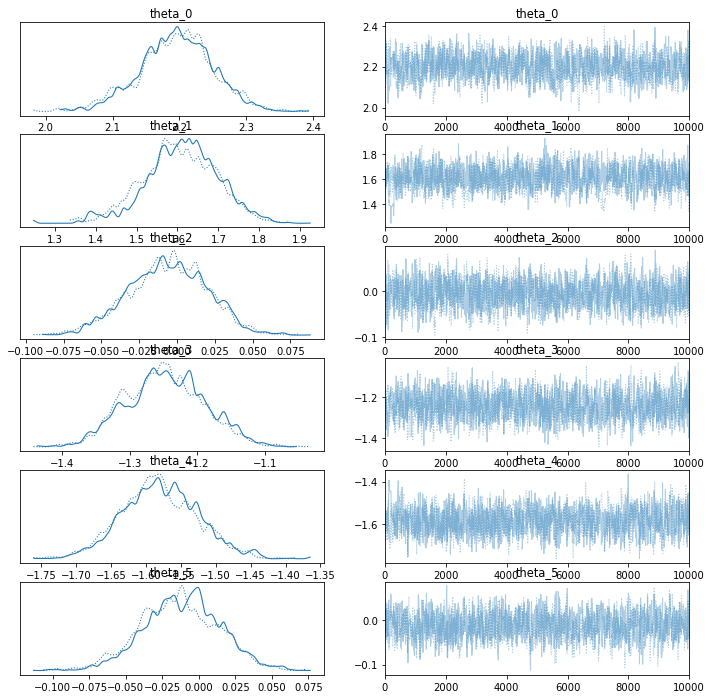

In [17]:
az.plot_trace(idata)
plt.show()